### Data Description:
You are provided with a dataset of images of plant seedlings at various stages of grown. Each image has a filename that is its
unique id. The dataset comprises 12 plant species. The goal of the project is to create a classifier capable of determining a plant's
species from a photo.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Reading the training images from the path and labelling them into the given categories
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns # for data visualization 
import tensorflow as tf
from tensorflow.keras.models import Sequential #sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten #importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses, optimizers

### **Reading the Training Data**

In [3]:
project_path = '/content/drive/My Drive/CV_project/'
data_X_file = project_path + "images.npy"
data_X = np.load(data_X_file)

In [4]:
data_Y = pd.read_csv(project_path + "Labels.csv")

In [5]:
data_X.shape

(4750, 128, 128, 3)

* Dataset contains 4750 images of size 128*128. The images seems to be an RGB image because the number of dimensions are 3

In [6]:
data_Y.shape

(4750, 1)

* There are 4750 labels

Label: Label    Small-flowered Cranesbill
Name: 10, dtype: object


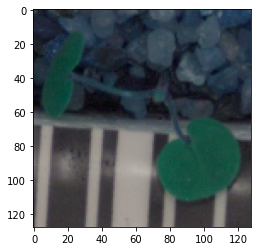

In [7]:

print("Label: {}".format(data_Y.iloc[10]))
plt.imshow(data_X[10])

### EDA

In [8]:
data_Y.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

* There are 12 types of plants. Dataset seems imbalanced with highest count 654 for Loose Silky-bent and lowest count 221 for Common wheat

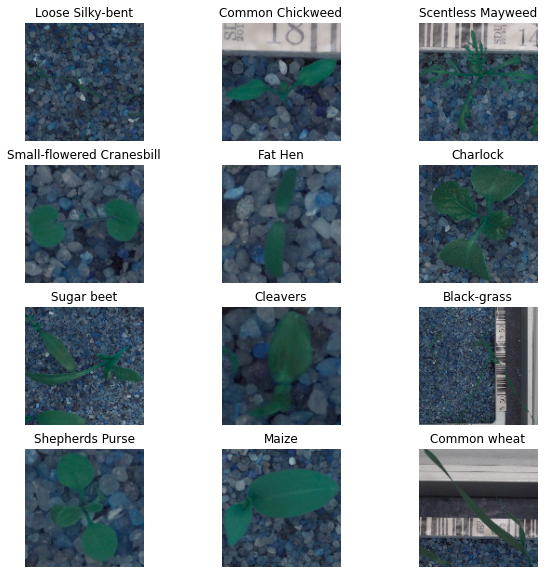

In [9]:
# Plotting the images for each category
fig = plt.figure(figsize = (10,10))
labels = ['Loose Silky-bent', 'Common Chickweed', 'Scentless Mayweed', 'Small-flowered Cranesbill', 'Fat Hen', 'Charlock', 'Sugar beet', 'Cleavers', 'Black-grass', 'Shepherds Purse', 'Maize', 'Common wheat']
i = 0
for label in labels:
  for index in range(0, 4750):
    if data_Y.iloc[index].iloc[0] == label:
      ax = fig.add_subplot(4, 3, i+1)
      i = i+1
      plt.imshow(data_X[index])  
      plt.title(label)
      plt.axis('off')
      break
plt.show()       

* These are the 12 types of plants in the data

#### Plotting the mean images of each class

In [10]:
dict = {}
for label in labels:
  indices = []
  for index in range(0, 4750):
    if data_Y.iloc[index].iloc[0] == label:
      indices.append(index)
  dict[label] = indices


In [11]:
dict.keys()

dict_keys(['Loose Silky-bent', 'Common Chickweed', 'Scentless Mayweed', 'Small-flowered Cranesbill', 'Fat Hen', 'Charlock', 'Sugar beet', 'Cleavers', 'Black-grass', 'Shepherds Purse', 'Maize', 'Common wheat'])

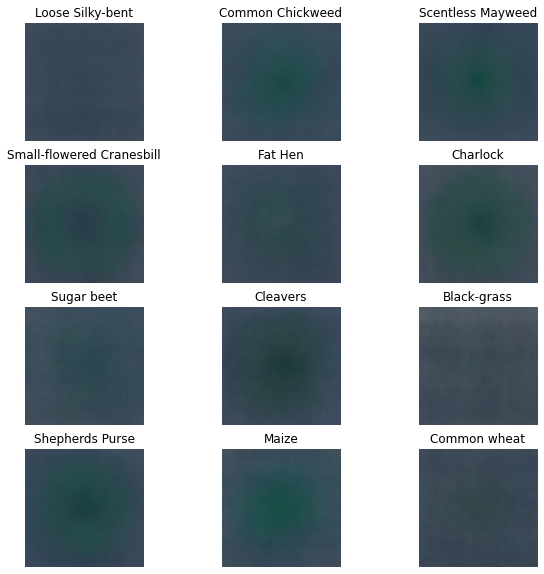

In [12]:
fig = plt.figure(figsize = (10,10))
i = 0
for label in dict.keys():
  mean_image_data = np.mean(data_X[dict.get(label)], axis = (0))

  ax = fig.add_subplot(4, 3, i+1)
  i = i+1
  plt.imshow(mean_image_data.astype('uint8'))
  plt.title(label)
  plt.axis('off') 
plt.show()    


* The mean images are not really interpretable. It may be the case that the plants are in different positions in different images

### Data Preprocessing

#### Gaussian blurring

In [13]:
blurred_images = []
for index in range(0, 4750):
  blurred_image = cv2.GaussianBlur(data_X[index], (5,5), 0)
  blurred_images.append(blurred_image)

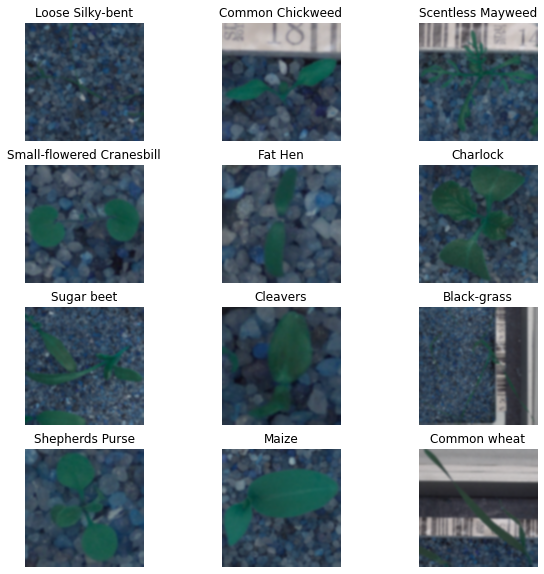

In [14]:
fig = plt.figure(figsize = (10,10))
labels = ['Loose Silky-bent', 'Common Chickweed', 'Scentless Mayweed', 'Small-flowered Cranesbill', 'Fat Hen', 'Charlock', 'Sugar beet', 'Cleavers', 'Black-grass', 'Shepherds Purse', 'Maize', 'Common wheat']
i = 0
for label in labels:
  for index in range(0, 4750):
    if data_Y.iloc[index].iloc[0] == label:
      ax = fig.add_subplot(4, 3, i+1)
      i = i+1
      plt.imshow(blurred_images[index])  
      plt.title(label)
      plt.axis('off')
      break
plt.show()  

* Here are the images after guassian blurring. We can clearly see the difference between original image and the blurred image

#### Normalization

In [15]:

normalized_images = np.array(blurred_images).astype('float32')
normalized_images = normalized_images/255

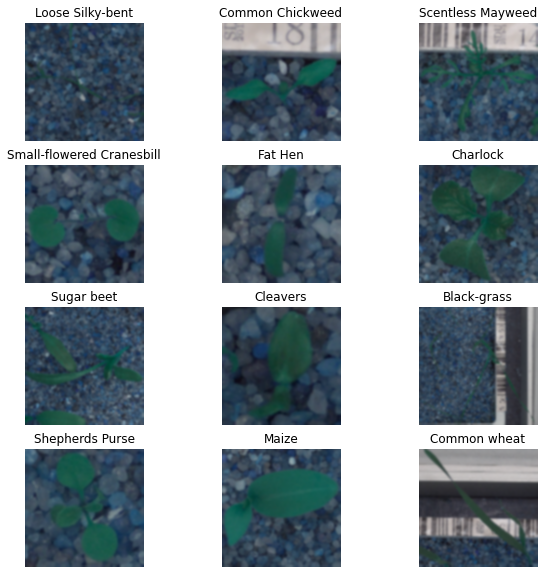

In [16]:
fig = plt.figure(figsize = (10,10))
labels = ['Loose Silky-bent', 'Common Chickweed', 'Scentless Mayweed', 'Small-flowered Cranesbill', 'Fat Hen', 'Charlock', 'Sugar beet', 'Cleavers', 'Black-grass', 'Shepherds Purse', 'Maize', 'Common wheat']
i = 0
for label in labels:
  for index in range(0, 4750):
    if data_Y.iloc[index].iloc[0] == label:
      ax = fig.add_subplot(4, 3, i+1)
      i = i+1
      plt.imshow(normalized_images[index])  
      plt.title(label)
      plt.axis('off')
      break
plt.show() 

* Images after normalization. They look no different after the normalization

#### Split into train and test data

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(normalized_images, data_Y, test_size=0.20, random_state=42)

In [69]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3800, 128, 128, 3)
(3800, 1)
(950, 128, 128, 3)
(950, 1)


### Make data compatible

In [70]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train).toarray()

In [71]:
y_test = enc.fit_transform(y_test).toarray()

In [72]:
type(y_test)

numpy.ndarray

In [73]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3800, 128, 128, 3)
(3800, 12)
(950, 128, 128, 3)
(950, 12)


In [74]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

### Model building

### CNN model 1

In [28]:
from tensorflow.keras.layers import Conv2D

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(128, 128, 3)))
model.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(12, activation="softmax"))

In [29]:
# Compile the model
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Fit the model
history = model.fit( x=X_train, y=y_train, batch_size=32, epochs=10, validation_split = 0.3)

Epoch 1/10
84/84 [==============================] - 41s 114ms/step - loss: 3.5098 - accuracy: 0.2842 - val_loss: 1.6631 - val_accuracy: 0.4193
Epoch 2/10
84/84 [==============================] - 9s 105ms/step - loss: 1.4784 - accuracy: 0.4737 - val_loss: 1.5385 - val_accuracy: 0.4851
Epoch 3/10
84/84 [==============================] - 9s 106ms/step - loss: 1.2194 - accuracy: 0.5684 - val_loss: 1.5600 - val_accuracy: 0.4851
Epoch 4/10
84/84 [==============================] - 9s 106ms/step - loss: 1.1822 - accuracy: 0.5861 - val_loss: 1.5481 - val_accuracy: 0.4895
Epoch 5/10
84/84 [==============================] - 9s 106ms/step - loss: 0.9494 - accuracy: 0.6835 - val_loss: 1.5184 - val_accuracy: 0.5202
Epoch 6/10
84/84 [==============================] - 9s 106ms/step - loss: 0.9219 - accuracy: 0.6744 - val_loss: 1.5317 - val_accuracy: 0.5421
Epoch 7/10
84/84 [==============================] - 9s 107ms/step - loss: 0.7613 - accuracy: 0.7417 - val_loss: 1.4527 - val_accuracy: 0.5728
Epoch

* Model 1 is giving an accuracy of 0.83 on training data and 0.55 on validation data. Clearly the model is overfitting. 0.55 accuracy on validation data seems to be low.

### CNN model 2

In [37]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(128, 128, 3)))
model2.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation="relu"))
model2.add(Dropout(rate=0.2))
model2.add(Dense(12, activation="softmax"))

In [39]:
# Compile the model
model2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Fit the model
history = model2.fit( x=X_train, y=y_train, batch_size=32, epochs=30, validation_split = 0.3)

Epoch 1/30
84/84 [==============================] - 6s 62ms/step - loss: 0.4948 - accuracy: 0.8331 - val_loss: 1.3063 - val_accuracy: 0.6360
Epoch 2/30
84/84 [==============================] - 5s 57ms/step - loss: 0.4278 - accuracy: 0.8605 - val_loss: 1.1379 - val_accuracy: 0.6789
Epoch 3/30
84/84 [==============================] - 5s 59ms/step - loss: 0.3453 - accuracy: 0.8868 - val_loss: 1.2896 - val_accuracy: 0.6640
Epoch 4/30
84/84 [==============================] - 5s 58ms/step - loss: 0.3053 - accuracy: 0.8977 - val_loss: 1.1685 - val_accuracy: 0.6912
Epoch 5/30
84/84 [==============================] - 5s 58ms/step - loss: 0.2370 - accuracy: 0.9222 - val_loss: 1.2468 - val_accuracy: 0.6623
Epoch 6/30
84/84 [==============================] - 5s 58ms/step - loss: 0.2185 - accuracy: 0.9256 - val_loss: 1.3248 - val_accuracy: 0.6439
Epoch 7/30
84/84 [==============================] - 5s 58ms/step - loss: 0.2088 - accuracy: 0.9293 - val_loss: 1.3795 - val_accuracy: 0.6675
Epoch 8/30
84

* Model 2 is giving an accuracy of 0.98 on training data and 0.63 on validation data. The model is still overfitting even after adding a pooling layer and drop out

### CNN model 3

In [49]:
from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
model3 = Sequential()
#
model3.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (128, 128, 3)))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.25))
#
model3.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model3.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model3.add(Dropout(0.25))
#
model3.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model3.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model3.add(Dropout(0.3))
#
model3.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model3.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model3.add(Dropout(0.3))

#
model3.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model3.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model3.add(Dropout(0.3))

# 
model3.add(Flatten())
model3.add(Dense(1024, activation = "relu"))
model3.add(Dropout(0.5))
model3.add(Dense(12, activation = "softmax"))
model3.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 200  
batch_size = 64


history=model3.fit(X_train, 
          y_train, 
          epochs=30, 
          batch_size=64,validation_split=0.20,callbacks=[es],use_multiprocessing=True)



Epoch 1/30
48/48 [==============================] - 14s 212ms/step - loss: 2.3507 - accuracy: 0.1990 - val_loss: 2.0634 - val_accuracy: 0.2645
Epoch 2/30
48/48 [==============================] - 7s 155ms/step - loss: 1.8697 - accuracy: 0.3526 - val_loss: 1.7692 - val_accuracy: 0.3816
Epoch 3/30
48/48 [==============================] - 7s 154ms/step - loss: 1.6395 - accuracy: 0.4135 - val_loss: 1.5377 - val_accuracy: 0.4658
Epoch 4/30
48/48 [==============================] - 7s 154ms/step - loss: 1.4250 - accuracy: 0.4836 - val_loss: 1.4537 - val_accuracy: 0.5132
Epoch 5/30
48/48 [==============================] - 7s 154ms/step - loss: 1.2056 - accuracy: 0.5734 - val_loss: 1.3269 - val_accuracy: 0.5539
Epoch 6/30
48/48 [==============================] - 7s 154ms/step - loss: 1.0689 - accuracy: 0.6168 - val_loss: 1.1847 - val_accuracy: 0.6211
Epoch 7/30
48/48 [==============================] - 7s 153ms/step - loss: 0.9492 - accuracy: 0.6582 - val_loss: 0.9028 - val_accuracy: 0.7118
Epoch

* Model 3 is giving an accuracy of 0.93 on training data and 0.81 on validation data. The model performance has been improved a lot with this architecture. Using early callback has helped with reducing overfitting

#### Evaluate on test data using model 3

In [75]:
model3.evaluate(X_test, y_test)

30/30 [==============================] - 1s 28ms/step - loss: 0.6652 - accuracy: 0.8137


[0.6651656031608582, 0.8136842250823975]

* Accuracy is 0.81

### Evaluate the model

In [76]:
# Test Prediction 
y_test_pred = model3.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_pred_prob = np.max(y_test_pred, axis=1)


In [77]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

In [78]:
y_pred = y_test_pred.argmax(axis=1)
y_test_arg_max = y_test.argmax(axis=1)

In [79]:
cf_matrix = confusion_matrix(y_test_arg_max, y_pred)
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)

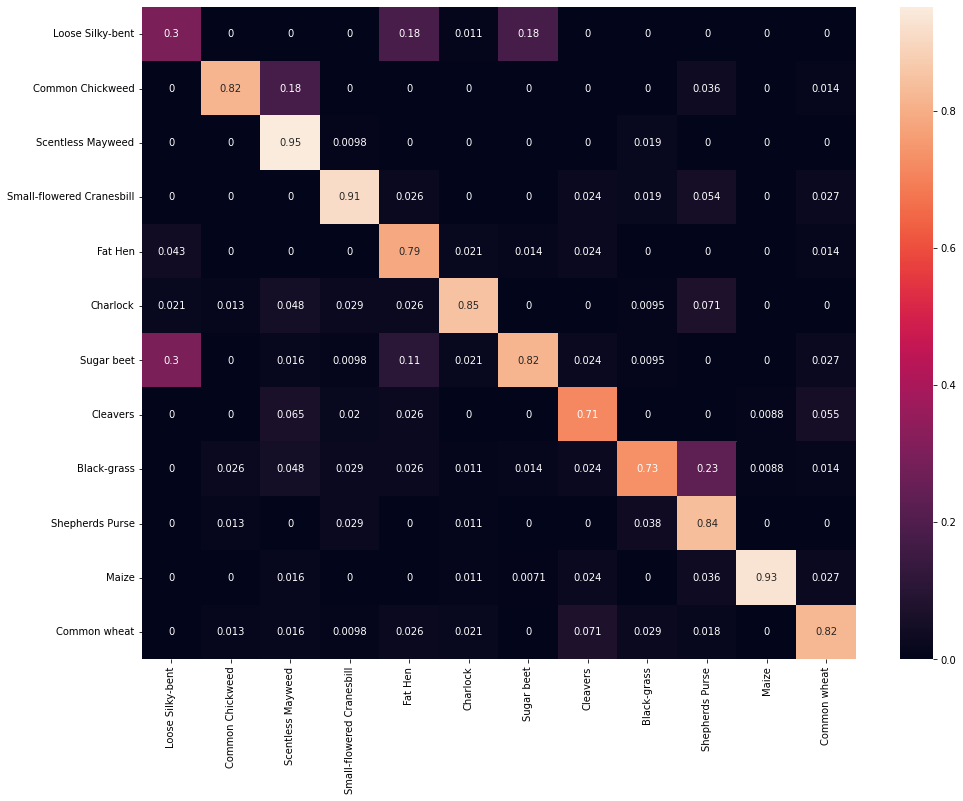

In [80]:
plt.figure(figsize=(16,12))
sns.heatmap(cf_matrix_n1, xticklabels=labels, yticklabels=labels, annot=True)

In [86]:
from sklearn.metrics import precision_recall_fscore_support  

p=precision_recall_fscore_support(y_test_arg_max, y_test_pred_classes, average=None,labels=list(np.unique(y_test_arg_max)))


print(" Precision is {}\n Recall is {} \n f_beta Score is {}".format(p[0],p[1],p[2]))

 Precision is [0.4516129  0.92537313 0.71084337 0.86915888 0.65217391 0.88888889
 0.79310345 0.78947368 0.85555556 0.65277778 0.98148148 0.82191781]
 Recall is [0.29787234 0.81578947 0.9516129  0.91176471 0.78947368 0.85106383
 0.81560284 0.71428571 0.73333333 0.83928571 0.92982456 0.82191781] 
 f_beta Score is [0.35897436 0.86713287 0.8137931  0.88995215 0.71428571 0.86956522
 0.8041958  0.75       0.78974359 0.734375   0.95495495 0.82191781]


* F beta score is very less for class 0 when compared to others. Except for class 0, remaining classes have f_beta score greater than 71%. Class 10 has the highest f_beta score with 95.4%
* Except for class 0, all the other classes have recall greater than 70%. Class 2 has the highest recall with 95%

### Conclusion and key take aways

Model 3 performs better compared to model 1 and model 2. I believe this could be because model 1 and 2 are very simple and probably couldn't capture all the features in the data


**There is still scope for improvement in the test accuracy and F1 score of the CNN model** chosen here. **Different architectures** can be built and **hyperparamter tuning** can be performed to obtain a better brain tumor classifier. 

We can visualize the filters  and understand why the model does not do well in the identification of class 0
